<a href="https://colab.research.google.com/github/cjsdudwls1/simple_things/blob/main/0908_%EC%95%84%ED%94%8C%EB%9D%BC%ED%86%A1%EC%8B%A0_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_%EC%A1%B0%EC%83%81%EA%B5%AC_0909_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%8B%A4%EC%9A%B4%EC%82%AC%EC%9D%B4%EC%A7%95%2Bdata_split%2B%EC%97%AC%EB%9F%AC_smote%EC%9D%98_%ED%81%B4%EB%A1%9C%EB%93%9C_%EC%9A%A9_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# 1. Train/Test 분리 (먼저 해야 함!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 변수 유형 분리
numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# 전처리 파이프라인
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder='passthrough'
)

### 2.3. 하이퍼파라미터 튜닝 및 교차 검증
GridSearchCV를 사용해 정의된 파라미터 그리드에 따라 최적의 하이퍼파라미터를 찾고, 교차 검증을 수행합니다.

1. 하이퍼파라미터 그리드 정의:

튜닝할 XGBClassifier의 파라미터를 딕셔너리 형태로 정의합니다. 파이프라인 객체 내 모델 이름(classifier)과 파라미터 이름을 함께 사용합니다.

2. 교차 검증 (StratifiedKFold):

불균형 데이터셋의 경우 StratifiedKFold를 사용해 타겟 클래스의 비율을 유지하며 데이터를 나눕니다.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 사용할 SMOTE 기법들
smote_methods = {
    "SMOTE": SMOTE(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42),
    "SVMSMOTE": SVMSMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42)
}

# 결과 저장용
results = {}

# 반복문으로 각 SMOTE 기법 적용
for name, smote in smote_methods.items():
    print(f"\n=== Running with {name} ===")

    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])

    # 교차 검증 설정
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 하이퍼파라미터 튜닝 (너무 오래 걸리지 않게 기본값)
    param_distributions = {}  # 지금은 비워둠

    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=10,  # param_distributions 비워둔 경우 의미 없음
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    # 성능 기록
    score = random_search.best_estimator_.score(X_test, y_test)
    results[name] = score
    print(f"{name} Test Score: {score:.4f}")

# 최종 결과 비교
print("\n=== Summary of SMOTE methods ===")
for method, score in results.items():
    print(f"{method}: {score:.4f}")


=== Running with SMOTE ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SMOTE Test Score: 0.9277

=== Running with BorderlineSMOTE ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
BorderlineSMOTE Test Score: 0.9732

=== Running with SVMSMOTE ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVMSMOTE Test Score: 0.9743

=== Running with ADASYN ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
ADASYN Test Score: 0.9257

=== Summary of SMOTE methods ===
SMOTE: 0.9277
BorderlineSMOTE: 0.9732
SVMSMOTE: 0.9743
ADASYN: 0.9257


# 기존 교수님코드에서 수정점
1. train_test_split: 전체 데이터에서 20%는 Test로 분리 → 성능 평가용.

2. 여러 SMOTE 기법 비교: for 반복문으로 돌면서 각각 Recall 중심 성능 측정.

3. 결과 기록: results 딕셔너리에 SMOTE 기법별 Test 성능 저장 및 출력.

### 2.3. 결과 확인
튜닝이 완료된 후, 최적의 하이퍼파라미터와 교차 검증 결과를 확인합니다.


DETAILED EVALUATION FOR EACH SMOTE METHOD

==================== SMOTE DETAILED ANALYSIS ====================

📊 Classification Report for SMOTE:
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     22587
           1       0.03      0.43      0.06       112

    accuracy                           0.93     22699
   macro avg       0.51      0.68      0.51     22699
weighted avg       0.99      0.93      0.96     22699

🎯 ROC AUC Score: 0.8540
🎯 Average Precision Score: 0.0788

==================== BorderlineSMOTE DETAILED ANALYSIS ====================

📊 Classification Report for BorderlineSMOTE:
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22587
           1       0.04      0.18      0.06       112

    accuracy                           0.97     22699
   macro avg       0.52   

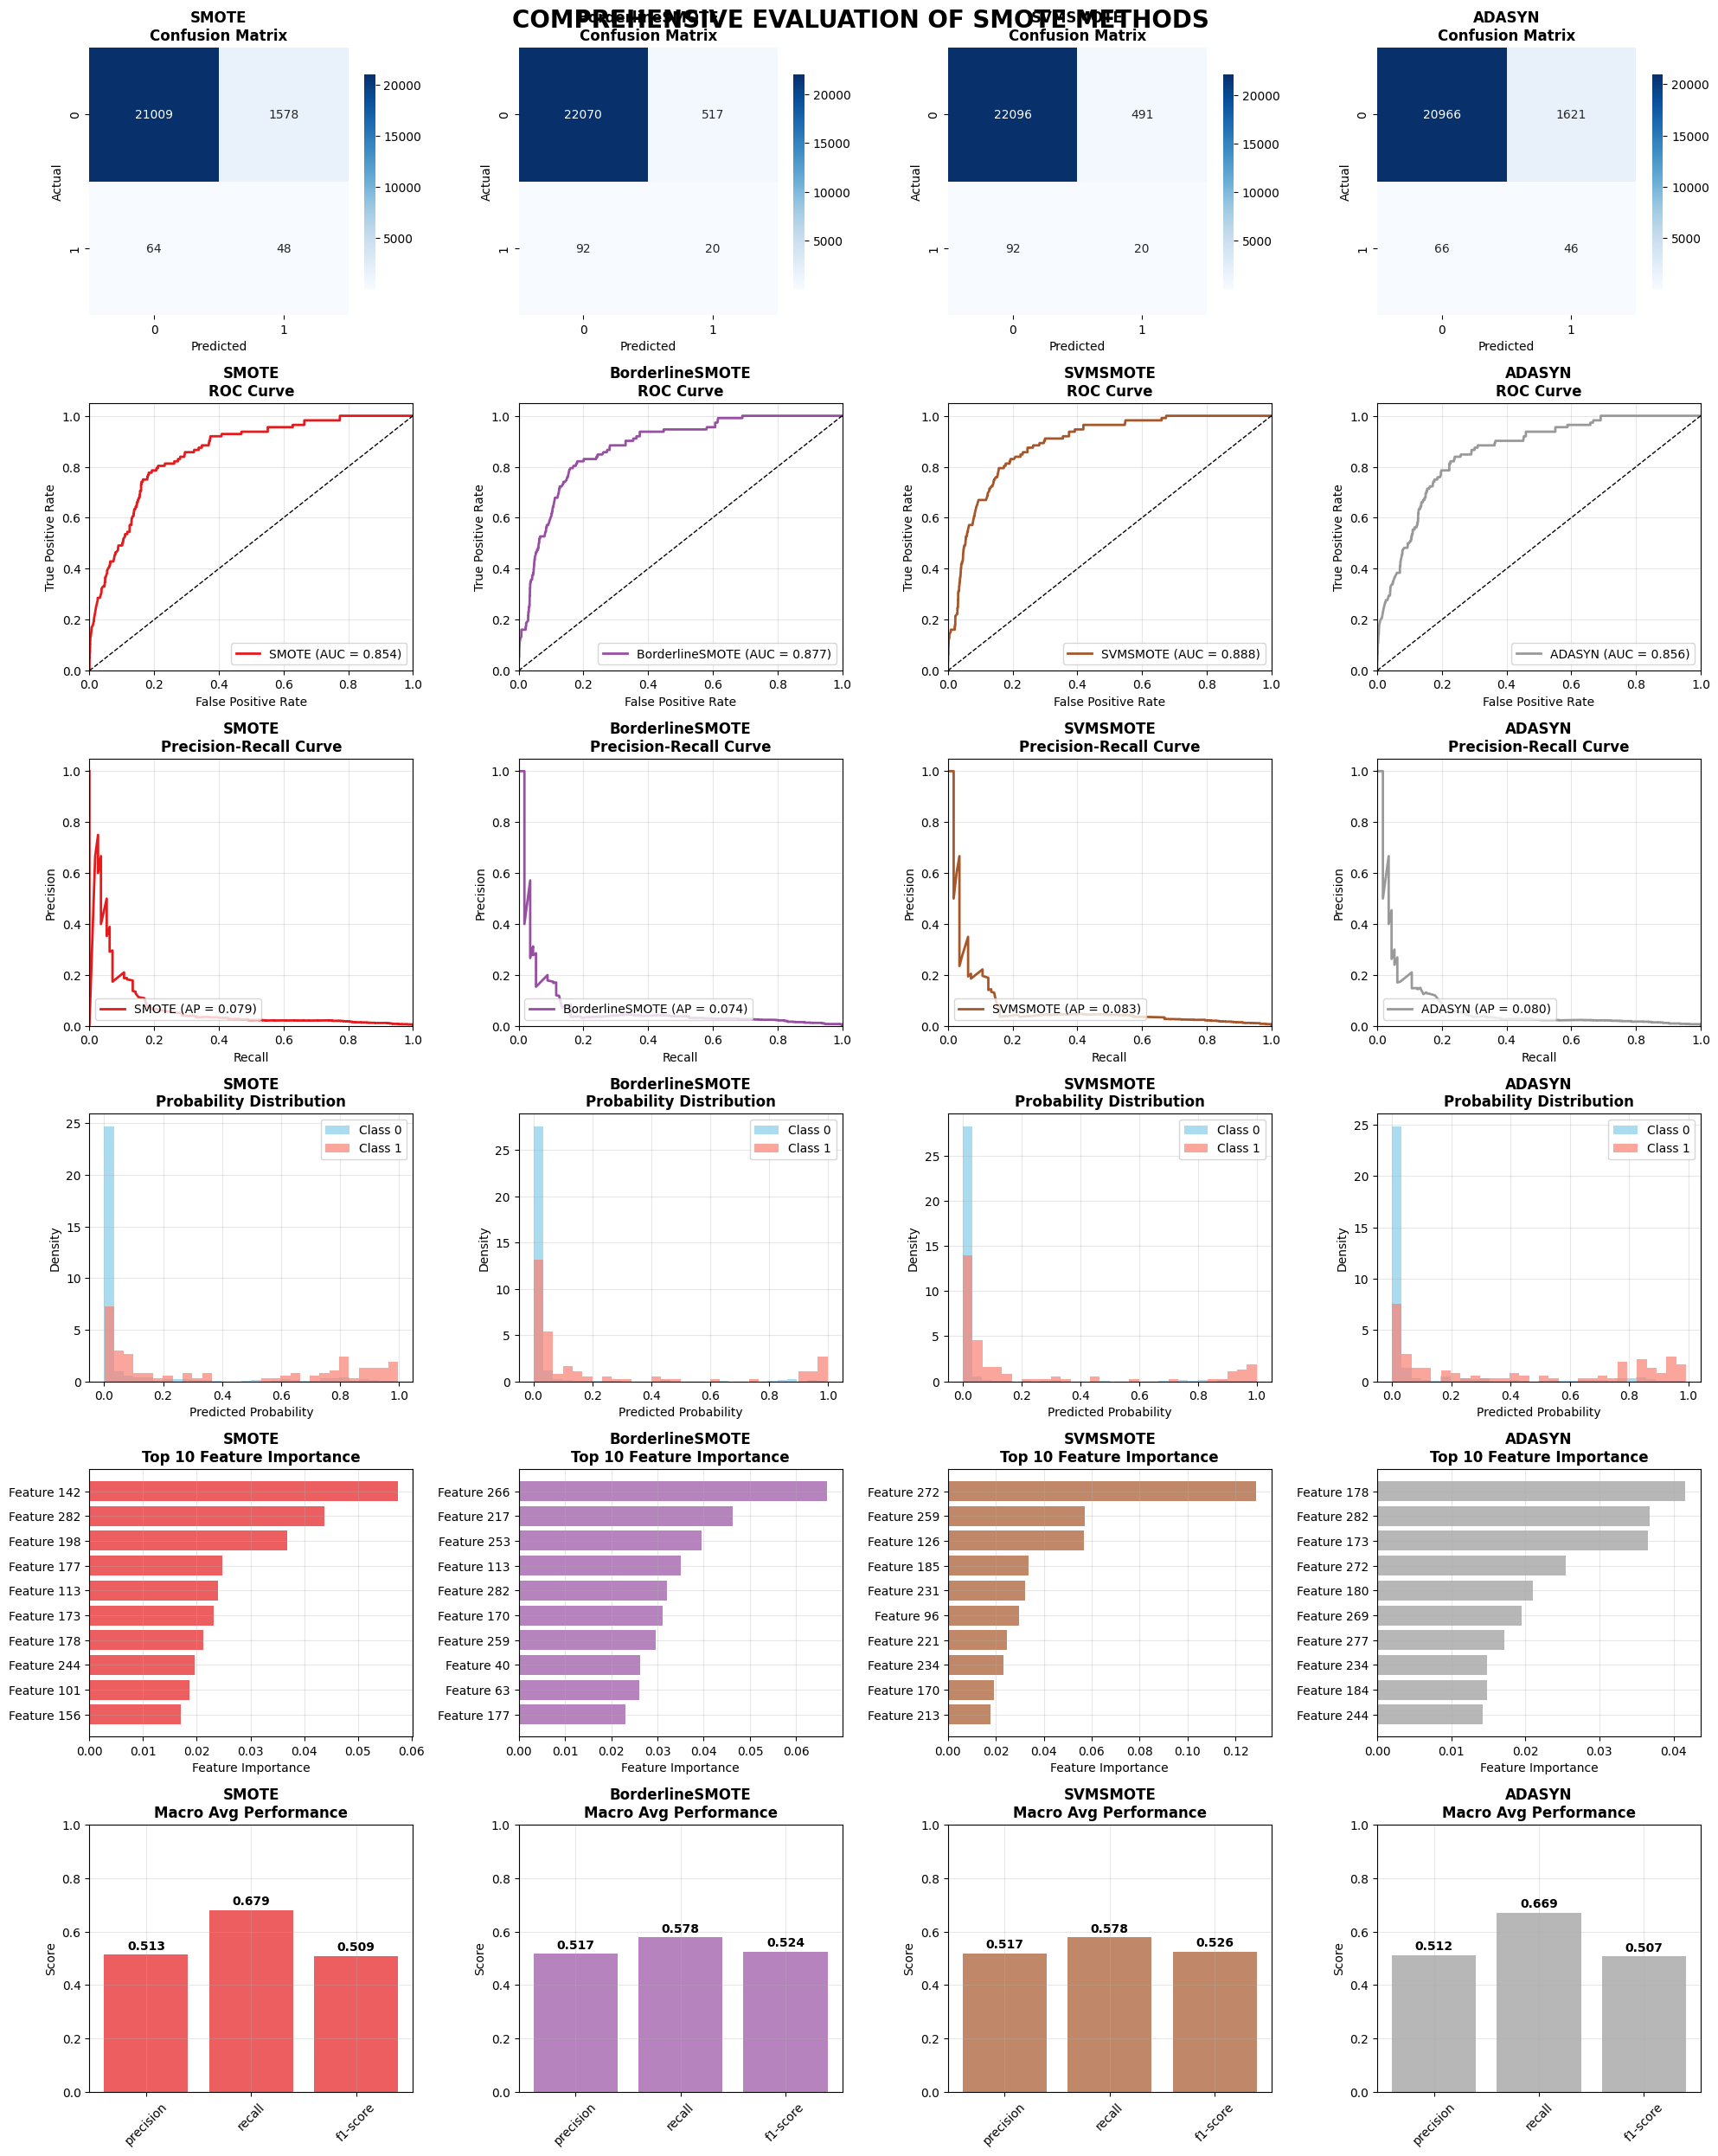


📈 COMPREHENSIVE PERFORMANCE COMPARISON
         Method  ROC AUC  Avg Precision  Macro Precision  Macro Recall  Macro F1
          SMOTE   0.8540         0.0788           0.5132        0.6794    0.5088
BorderlineSMOTE   0.8767         0.0741           0.5165        0.5778    0.5240
       SVMSMOTE   0.8881         0.0827           0.5175        0.5784    0.5256
         ADASYN   0.8564         0.0798           0.5122        0.6695    0.5065

🏆 BEST PERFORMING METHODS:
   • Best ROC AUC: SVMSMOTE (0.8881)
   • Best Macro F1: SVMSMOTE (0.5256)
   • Best Avg Precision: SVMSMOTE (0.0827)

ANALYSIS COMPLETE! 🎉


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (15, 10)

# 결과 저장용 딕셔너리 확장
detailed_results = {}

print("\n" + "="*80)
print("DETAILED EVALUATION FOR EACH SMOTE METHOD")
print("="*80)

# 각 SMOTE 방법별로 상세 평가
for name, smote in smote_methods.items():
    print(f"\n{'='*20} {name} DETAILED ANALYSIS {'='*20}")

    # 파이프라인 재구성
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])

    # 학습 및 예측
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # 1. Classification Report
    print(f"\n📊 Classification Report for {name}:")
    print("-" * 50)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    # 2. 각종 메트릭 계산
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    # 결과 저장
    detailed_results[name] = {
        'pipeline': pipeline,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'classification_report': report,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision
    }

    print(f"🎯 ROC AUC Score: {roc_auc:.4f}")
    print(f"🎯 Average Precision Score: {avg_precision:.4f}")

# 시각화
n_methods = len(smote_methods)
fig = plt.figure(figsize=(20, 25))

# 색상 팔레트 설정
colors = plt.cm.Set1(np.linspace(0, 1, n_methods))

for idx, (name, results_data) in enumerate(detailed_results.items()):
    y_pred = results_data['y_pred']
    y_pred_proba = results_data['y_pred_proba']
    color = colors[idx]

    # 1. Confusion Matrix
    plt.subplot(6, n_methods, idx + 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar_kws={'shrink': 0.8})
    plt.title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 2. ROC Curve
    plt.subplot(6, n_methods, n_methods + idx + 1)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name}\nROC Curve', fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)

    # 3. Precision-Recall Curve
    plt.subplot(6, n_methods, 2*n_methods + idx + 1)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, color=color, lw=2,
             label=f'{name} (AP = {avg_precision:.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name}\nPrecision-Recall Curve', fontweight='bold')
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(True, alpha=0.3)

    # 4. Predicted Probability Distribution
    plt.subplot(6, n_methods, 3*n_methods + idx + 1)
    # 클래스별 확률 분포
    prob_class_0 = y_pred_proba[y_test == 0]
    prob_class_1 = y_pred_proba[y_test == 1]

    plt.hist(prob_class_0, bins=30, alpha=0.7, label='Class 0',
             color='skyblue', density=True)
    plt.hist(prob_class_1, bins=30, alpha=0.7, label='Class 1',
             color='salmon', density=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title(f'{name}\nProbability Distribution', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Feature Importance (XGBoost의 경우)
    plt.subplot(6, n_methods, 4*n_methods + idx + 1)
    try:
        # 전처리된 특성 이름 생성
        feature_names = []
        if len(numerical_features) > 0:
            feature_names.extend([f'num_{col}' for col in numerical_features])
        if len(categorical_features) > 0:
            # OneHotEncoder로 인한 확장된 특성명은 간단히 처리
            feature_names.extend([f'cat_{i}' for i in range(len(categorical_features)*10)])  # 대략적 추정

        classifier = results_data['pipeline'].named_steps['classifier']
        importances = classifier.feature_importances_

        # 상위 10개 특성만 표시
        top_indices = np.argsort(importances)[-10:]
        top_importances = importances[top_indices]

        plt.barh(range(len(top_importances)), top_importances, color=color, alpha=0.7)
        plt.xlabel('Feature Importance')
        plt.title(f'{name}\nTop 10 Feature Importance', fontweight='bold')
        plt.yticks(range(len(top_importances)), [f'Feature {i}' for i in top_indices])
        plt.grid(True, alpha=0.3)
    except Exception as e:
        plt.text(0.5, 0.5, f'Feature importance\nnot available\n({str(e)[:30]}...)',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'{name}\nFeature Importance', fontweight='bold')

    # 6. 성능 메트릭 바차트
    plt.subplot(6, n_methods, 5*n_methods + idx + 1)
    report = results_data['classification_report']
    metrics = ['precision', 'recall', 'f1-score']

    # 클래스별 성능 (매크로 평균 사용)
    macro_scores = [report['macro avg'][metric] for metric in metrics]

    bars = plt.bar(metrics, macro_scores, color=[color]*3, alpha=0.7)
    plt.ylim([0, 1])
    plt.ylabel('Score')
    plt.title(f'{name}\nMacro Avg Performance', fontweight='bold')
    plt.xticks(rotation=45)

    # 바 위에 값 표시
    for bar, score in zip(bars, macro_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('COMPREHENSIVE EVALUATION OF SMOTE METHODS',
             fontsize=20, fontweight='bold', y=0.995)
plt.show()

# 종합 성능 비교표 출력
print("\n" + "="*80)
print("📈 COMPREHENSIVE PERFORMANCE COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Method': list(detailed_results.keys()),
    'ROC AUC': [detailed_results[method]['roc_auc'] for method in detailed_results.keys()],
    'Avg Precision': [detailed_results[method]['avg_precision'] for method in detailed_results.keys()],
    'Macro Precision': [detailed_results[method]['classification_report']['macro avg']['precision']
                       for method in detailed_results.keys()],
    'Macro Recall': [detailed_results[method]['classification_report']['macro avg']['recall']
                    for method in detailed_results.keys()],
    'Macro F1': [detailed_results[method]['classification_report']['macro avg']['f1-score']
                for method in detailed_results.keys()]
})

# 소수점 4자리로 반올림
comparison_df = comparison_df.round(4)
print(comparison_df.to_string(index=False))

# 최고 성능 방법 찾기
best_roc_auc = comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Method']
best_f1 = comparison_df.loc[comparison_df['Macro F1'].idxmax(), 'Method']
best_precision = comparison_df.loc[comparison_df['Avg Precision'].idxmax(), 'Method']

print(f"\n🏆 BEST PERFORMING METHODS:")
print(f"   • Best ROC AUC: {best_roc_auc} ({comparison_df['ROC AUC'].max():.4f})")
print(f"   • Best Macro F1: {best_f1} ({comparison_df['Macro F1'].max():.4f})")
print(f"   • Best Avg Precision: {best_precision} ({comparison_df['Avg Precision'].max():.4f})")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE! 🎉")
print(f"{'='*80}")